In [2]:
# Import JAX
from jax.config import config
config.update("jax_enable_x64", True)
from jax import random, devices
from jax.lib import xla_bridge
import numpy as np
import jax

# Import Hybrid Rosenbrock
import sys
sys.path.append("..")
from models.JAXHRD import hybrid_rosenbrock

import corner

# Ensure that GPU is found
print(devices())
print(xla_bridge.get_backend().platform)

/tmp/ipykernel_885276/551052051.py:2: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config
I0000 00:00:1702922796.562022  885276 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[CpuDevice(id=0)]
cpu


In [3]:
# Define Hybrid Rosenbrock model
n2 = 3
n1 = 4
DoF = n2 * (n1 - 1) + 1
B = np.zeros(DoF)
B[0] = 30
B[1:] = 20
mu=1
model = hybrid_rosenbrock(n2, n1, mu, B, seed=35)

# Draw i.i.d samples
iid_samples = model.newDrawFromPosterior(50000000)
truth_table = ((iid_samples > model.lower_bound) & (iid_samples < model.upper_bound))
idx = np.where(np.all(truth_table, axis=1))[0]
print('%i samples obtained from rejection sampling' % idx.shape[0])
bounded_iid_samples = iid_samples[idx]

6780811 samples obtained from rejection sampling


# Get samples with jaxns

In [6]:
# Import jaxns
import tensorflow_probability.substrates.jax as tfp
from jaxns import DefaultNestedSampler
from jaxns import Model
from jaxns import PriorModelGen, Prior
from jaxns import TerminationCondition
from jaxns import save_results, load_results
from jaxns.utils import resample

tfpd = tfp.distributions

def prior_model() -> PriorModelGen:
    x = yield Prior(tfpd.Uniform(low=model.lower_bound, high=model.upper_bound), name='x')
    return x

jaxns_model = Model(prior_model=prior_model, log_likelihood=jax.jit(lambda x: -1 * model.getMinusLogPosterior(x)))

# exact_ns = ExactNestedSampler(model=jaxns_model, num_live_points=1000, num_parallel_samplers=1, max_samples=1e5)
exact_ns = DefaultNestedSampler(model=jaxns_model, num_live_points=1000, max_samples=1e5)

# Try JIT?
# exact_ns = jax.jit(ExactNestedSampler)(model=jaxns_model, num_live_points=1000, num_parallel_samplers=1, max_samples=1e5)

# Termination condition on Z
# termination_reason, state = exact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4))

# Termination condition on ESS
termination_reason, state = exact_ns(random.PRNGKey(42), term_cond=TerminationCondition(ess=1e4))

# Termination condition on total number of samples
# termination_reason, state = exact_ns(random.PRNGKey(42), term_cond=TerminationCondition(max_samples=1e5))

results = exact_ns.to_results(state, termination_reason)

/home/al44828/miniconda3/envs/cpu_samplers/lib/python3.11/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=int64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


AttributeError: 'ArrayImpl' object has no attribute 'next_sample_idx'

In [ ]:
# Save results?
# save_results(results, 'rosenbrock_jaxns_results')
print(results.ESS)
exact_ns.summary(results)
# exact_ns.plot_diagnostics(results)
# exact_ns.plot_cornerplot(results)

In [ ]:
# from jaxns import load_results 
# results = load_results('rosenbrock_jaxns_results.npz')

samples = resample(random.PRNGKey(42), results.samples, results.log_dp_mean, S=int(results.ESS))['x']
fig1 = corner.corner(bounded_iid_samples[0:30000], hist_kwargs={'density':True})
corner.corner(samples, color='r', fig=fig1, hist_kwargs={'density':True})


# Get samples with BlackJAX

In [ ]:
# BlackJAX Hello World!

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import numpy as np

import blackjax

observed = np.random.normal(10, 20, size=1_000)
def logdensity_fn(x):
      logpdf = stats.norm.logpdf(observed, x["loc"], x["scale"])
      return jnp.sum(logpdf)

# Build the kernel
step_size = 1e-3
inverse_mass_matrix = jnp.array([1., 1.])
nuts = blackjax.nuts(logdensity_fn, step_size, inverse_mass_matrix)

# Initialize the state
initial_position = {"loc": 1., "scale": 2.}
state = nuts.init(initial_position)

samples = []

# Iterate
rng_key = jax.random.key(0)
step = jax.jit(nuts.step)
for _ in range(1_000):
      rng_key, nuts_key = jax.random.split(rng_key)
      state, _ = step(nuts_key, state)
      samples.append(state.position['loc'])

In [32]:

observed.shape

(1000,)

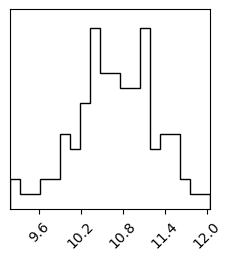

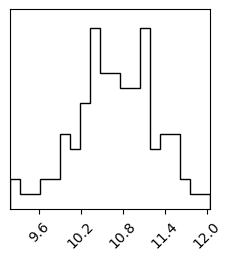

In [29]:
import corner
corner.corner(np.array(samples)[-100:])

In [28]:
np.array(samples).shape

(204,)

In [6]:
import corner

corner.corner(samples)

TypeError: '<=' not supported between instances of 'dict' and 'dict'

In [ ]:
from fastprogress import progress_bar


# 50k iterations
num_training_steps = 50000
schedule_fn = lambda k: 0.05 * k ** (-0.55)
schedule = [schedule_fn(i) for i in range(1, num_training_steps+1)]

grad_fn = lambda x, _: jax.grad(logprob_fn)(x)
sgld = blackjax.sgld(grad_fn)

rng_key = jax.random.PRNGKey(3)
init_position = -10 + 20 * jax.random.uniform(rng_key, shape=(2,))

position = sgld.init(init_position)
sgld_samples = []
for i in progress_bar(range(num_training_steps)):
    _, rng_key = jax.random.split(rng_key)
    position = jax.jit(sgld.step)(rng_key, position, 0, schedule[i])
    sgld_samples.append(position)

# TODO
___

(1) Draw samples using pymc's implementation of NUTS


1. Define numpyro likelihood

2. NUTS kernel?

3. run and get samples?

4. confirm jax + jit + gpu is properly used

In [ ]:
# This seems like the simplest case

# How do we input the prior ranges for each variable now????

# How to install numpyro without fucking up my jax distribution????

""" 
References
----------

https://forum.pyro.ai/t/user-distribution-sampling/3191

"""

kernel = NUTS(potential_fn=lambda x: -mixture_gaussian_model.logpdf(x))
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(PRNGKey(0), init_params=jnp.zeros(2))

In [ ]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_value

prior_sigma_Mc = 5.0
prior_sigma_eta = 0.1
prior_sigma_chi = 5.0
prior_sigma_D = 10.0

prior_sigma_tc = 0.1
prior_sigma_phic = np.pi


def numpyro_likelihood(f, sigma, y=None):
    # Parameters of the model
    log_Mc = numpyro.sample("log_Mc", dist.Normal(np.log(Mc), prior_sigma_Mc))
    eta_ = numpyro.sample("eta", dist.Uniform(0.0, 0.25))
    
    chi1_ = numpyro.sample("chi1", dist.Uniform(-1., 1.))
    chi2_ = numpyro.sample("chi2", dist.Uniform(-1., 1.))
    
    log_D = numpyro.sample("log_D", dist.Normal(np.log(D), prior_sigma_D))
    
    tc_ = numpyro.sample("tc", dist.Uniform(tc-prior_sigma_tc, tc+prior_sigma_tc))
    
    phi_param = numpyro.sample("phi_param", dist.Normal(0., 1.0), sample_shape=(2,))
    phic_ = numpyro.deterministic("phic", 0.5 * jnp.arctan2(phi_param[1], phi_param[0]))
#     phic_ = numpyro.sample("phic", dist.Normal(phic, prior_sigma_phic))
    
    # This is the part I'm not sure I understand...
    # I'm not sure which part should be data and which part is 
    params = jnp.array([jnp.exp(log_Mc), eta_, chi1_, chi2_, jnp.exp(log_D), tc_, phic_])
    waveform = gen_IMRPhenomD(f, params)
    
    # Likelihood definition
    numpyro.sample(
        "real_obs", dist.Normal(waveform.real, sigma), obs=None if y is None else y.real
    )
    numpyro.sample(
        "imag_obs", dist.Normal(waveform.imag, sigma), obs=None if y is None else y.imag
    )



init = {
"log_Mc": np.log(Mc),
"eta": eta,
"chi1": chi1,
"chi2": chi2,
"log_D": np.log(D),
"tc": tc,
"phi_param": np.array([np.cos(phic), np.sin(phic)]),
}
nuts_kernel = NUTS(
    numpyro_likelihood, dense_mass=True, target_accept_prob=0.9,
    init_strategy=init_to_value(values=init)
)
mcmc = MCMC(
    nuts_kernel,
    num_warmup=1000,
    num_samples=1000,
    num_chains=2,
    progress_bar=True,
)
rng_key = jax.random.PRNGKey(34923)

mcmc.run(rng_key, f_list[:1500], sigma_list[:1500], y=data[:1500])
samples = mcmc.get_samples()

In [ ]:
def model():
    # replace Uniform by ImproperUniform for other kinds of supports
    x = numpyro.sample("x", dist.Uniform(...))
    numpyro.factor("log_prob", your_custom_log_prob(x))

nuts_kernel = NUTS(numpyro_likelihood,
                   dense_mass=True,
                   target_accept_prob=0.9,
                   init_strategy=init_to_value(values=init))

mcmc = MCMC(
    nuts_kernel,
    num_warmup=1000,
    num_samples=1000,
    num_chains=2,
    progress_bar=True,
)

rng_key = jax.random.PRNGKey(34923)

mcmc.run(rng_key, f_list[:1500], sigma_list[:1500], y=data[:1500])
samples = mcmc.get_samples()

In [ ]:
import jax.numpy as jnp
import jax.random as random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

###
# How do we feed in our likelihood to this? Also, how do we make sure JAX is being utilized???
###


def model(x, y=None, y_err=0.1):

    # define parameters (incl. prior ranges)
    l = numpyro.sample('l', dist.Uniform(-2, 2))
    m = numpyro.sample('m', dist.Uniform(-2, 2))
    s = numpyro.sample('s', dist.Uniform(0, 2))
    a = numpyro.sample('a', dist.Uniform(-2, 2))
    b = numpyro.sample('b', dist.Uniform(-2, 2))

    # implement the model
    # needs jax numpy for differentiability here
    peak = l * jnp.exp(-(m-x)**2 / (2*s**2))
    background  = a + b*x
    y_model = peak + background

    # notice that we clamp the outcome of this sampling to the observation y
    numpyro.sample('obs', dist.Normal(y_model, y_err), obs=y)

# need to split the key for jax's random implementation
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# run HMC with NUTS
kernel = NUTS(model, target_accept_prob=0.9)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=3000)
mcmc.run(rng_key_, x=x, y=y, y_err=y_err)
mcmc.print_summary()